In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
BUILD_DATA = True
np.random.seed(1)

class HairNetData():
    IMG_DIR = 'training-data/gaussian/images'
    IMG_SIZE = 200  # 200x200
    PARAM_DIR = 'training-data/gaussian/parameters.csv'
    data = []
    data_count = 0
    
    def open_data(self):
        params_df = pd.read_csv(self.PARAM_DIR)
        
        for file in tqdm(os.listdir(self.IMG_DIR)):
            try:
                # load image
                path = os.path.join(self.IMG_DIR, file)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                # load param for the image
                param = params_df.loc[params_df['file_name'] == file] # get params with that file name
                param = param.drop(columns=['file_name']) # drops filename column

                # adding to data
                self.data.append([np.array(img), param.to_numpy()])
                self.data_count += 1
            except Exception as e:
                print(str(e))
            
        assert self.data_count == 3000
        np.random.shuffle(self.data)
        np.save('data.npy', self.data)
        print(f'count: {self.data_count}')
        

        
if BUILD_DATA:
    hairnetdata = HairNetData()
    hairnetdata.open_data()
    BUILD_DATA = False


100%|██████████| 3000/3000 [00:09<00:00, 308.44it/s]


count: 3000


In [4]:
data = np.load('data.npy', allow_pickle=True)

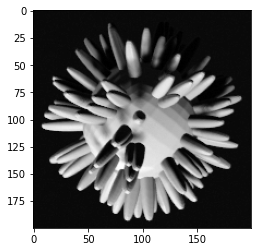

In [5]:
import matplotlib.pyplot as plt

plt.imshow(data[0][0], cmap='gray')
plt.show()

In [6]:
data[0][1]

array([[1.24815032e+00, 1.30705615e+00, 1.30579933e+00, 1.01283066e+01,
        6.92943852e-01, 1.08895046e-01, 4.91818875e+00, 1.27000000e+02,
        2.34823166e-01]])

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [15]:
class HairNet1(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.conv3 = nn.Conv2d(64, 128, 5, 1)
        self.conv4 = nn.Conv2d(128, 128, 5, 1)
        self.conv5 = nn.Conv2d(128, 128, 5, 1)
        
        #output size: (input - kernel + 2*padding)/stride + 1
        x = torch.rand(200, 200).view(-1,1,200,200)
        self._lin_shape = None
        self._conv_pass(x)
        
        self.fc1 = nn.Linear(self._lin_shape, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 9) # we need 9 parameters
        
    def _conv_pass(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv5(x)), (2, 2))
        
        if self._lin_shape is None:
            self._lin_shape = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
        
        
        
        # todo linear
    def forward(self, x):
        x = self._conv_pass(x)
        x = x.view(-1, self._lin_shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) # Rectified!
        return x
        
        
net = HairNet1()

In [20]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.MSELoss()

imgs = torch.Tensor([d[0] for d in data])
imgs /= 255.0 # to get pixel values on [0, 1]
params = torch.Tensor([d[1] for d in data])

test_size = len(imgs) // 10  # 1/10 of all data

# Spliting data into training and testing
test_imgs = imgs[-test_size:]
test_params = params[-test_size:]

train_imgs = imgs[:-test_size]
train_params = params[:-test_size]

assert len(test_imgs) == len(test_params)
assert len(train_imgs) == len(train_params)

print(len(test_imgs))
print(len(train_imgs))

300
2700


In [25]:
BATCH = 10
EPOCH = 1

for epoch in tqdm(range(EPOCH)):
    for i in tqdm(range(0, len(train_imgs), BATCH)):
        batch_imgs = train_imgs[i:i+BATCH].view(-1, 1, 200, 200)
        batch_params = train_params[i:i+BATCH]
        
        net.zero_grad()
        out = net(batch_imgs)
        loss = loss_func(out, batch_params)
        
        loss.backward()
        optimizer.step()

print(loss)

  0%|          | 0/270 [00:00<?, ?it/s]/Users/alexkalinins/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([10, 1, 9])) that is different to the input size (torch.Size([10, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

  0%|          | 0/1 [00:27<?, ?it/s]


KeyboardInterrupt: 